- 2021.08.20  u.k.  transfer 1d with FAL model

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
import numpy as np

#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

In [4]:
from spectra_src.Util import HelpUtil

from spectra_src.Struct import Atom as Atom
from spectra_src.Experimental import ExFAL as _ExFAL
from spectra_src.Experimental import ExSpectrum as _ExSpectrum
from spectra_src.Experimental import ExScatter as _ExScatter
from spectra_src.Atomic import BasicP as _BasicP
from spectra_src.RadiativeTransfer import Profile as _Profile
from spectra_src.Atomic import Hydrogen as _Hydrogen
from spectra_src.Atomic import LTELib as _LTELib
#from spectra_src.Function.Hydrogen import DegenerateN as _DegenerateN

#from spectra_src.Atomic import ContinuumOpacity as _ContinuumOpacity

from spectra_src.Function.SEquil import SELib as _SELib

---

In [5]:
import os

conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H6.conf" )
atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=True)

In [6]:
FAL_path = os.path.join( CFG._ROOT_DIR, "data/atmos/FAL/FALC_82.atmos" )
pop_con, atmos = _ExFAL.init_FAL_(FAL_path)
spectrum = _ExSpectrum.init_spectrum_(atom=atom, wMesh=wMesh, Te=atmos.Te.min(), Vt=atmos.Vt.min() )

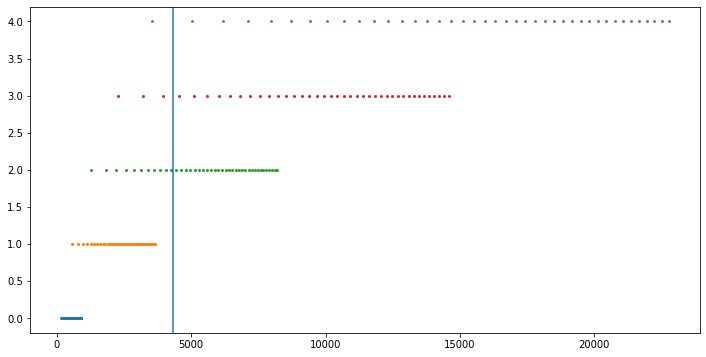

In [19]:
fig = plt.figure(figsize=(12,6))
for k in range(5):
    plt.plot(wMesh.Cont_mesh[k,:]*1E8, [k,]*41, "o", markersize=2)
plt.axvline(x=4341)
plt.show()

In [20]:
nZ = atmos.Z.size

# pre-calculate LTE population
nH_pop_LTE = np.empty((nZ, atom.nLevel), dtype="float64")
for kz in range(nZ):
    nH_pop_LTE[kz,:], _ = _SELib._ni_nj_LTE_(atom.Level, atom.Line, atom.Cont, atmos.Te[kz], atmos.Ne[kz])

In [21]:
# background opacity, emissivity and scattering coefficient
alp_c = np.empty((spectrum.nSpectrum,nZ), dtype="float64")
eta_c = np.empty((spectrum.nSpectrum,nZ), dtype="float64")
eps_c = np.empty((spectrum.nSpectrum,nZ), dtype="float64")
for ks in range(spectrum.nSpectrum):
    #print(f"\r{ks}/{spectrum.nSpectrum}", end="")
    wave = spectrum.spectrum[ks]
    
    # pre-calculate background opacity
    for kz in range(nZ):

        nH_pop = pop_con.n_population[kz,:]
        nH = atmos.Nh[kz]
        Te = atmos.Te[kz]
        ne = atmos.Ne[kz]
        alp_c[ks,kz], eta_c[ks,kz], eps_c[ks,kz] = _ExScatter.background_opacity_(wave, nH_pop_LTE[kz,:], nH_pop, nH, ne, Te)

In [22]:
Jbar = np.zeros((spectrum.nSpectrum, nZ), dtype="float64")

In [23]:
# (base opacity)  background : thomson, rayleigh, H-, H2+, H+-ff, (LTE)... 
# (active opacity)radiative transfer : (atomic-model) bound-bound (line), bound-free (continuum)

# calculate transition (radiative transfer) opacity and emissivity (bound-bound + bound-free)
Line = atom.Line
Level = atom.Level
Cont = atom.Cont


# calculate bound-free cross section
cross_sec = np.zeros((atom.nCont, spectrum.nSpectrum))
for ks in range(spectrum.nSpectrum):
    wave = spectrum.spectrum[ks]
    cross_sec[:,ks] = _Hydrogen.PI_cross_section_cm_(Cont["ni"][:], wave, 1)


alp_rt = np.zeros((spectrum.nSpectrum,nZ), dtype="float64")
eta_rt = np.zeros((spectrum.nSpectrum,nZ), dtype="float64")

fourpi = 4. * CST.pi_

for ks in range(spectrum.nSpectrum):
#    print(f"\r{ks}/{spectrum.nSpectrum}", end="")
    wave = spectrum.spectrum[ks] # [cm]
    for kl in spectrum.belonging_line[ks,:]:
        if kl == -1:
            break
        Aji = Line["AJI"][kl]
        Bji = Line["BJI"][kl]
        Bij = Line["BIJ"][kl]
        f0 = Line["f0"][kl]
        hv = CST.h_ * f0
        w0 = Line["w0"][kl]
        
        dopWidth_cm = _BasicP.doppler_width_(w0, atmos.Te[:], atmos.Vt[:], atom.Mass)
        dopWidth_hz = dopWidth_cm * f0 / w0
        ni = pop_con.n_population[ :,Line["idxI"][kl] ] # [-]
        nj = pop_con.n_population[ :,Line["idxJ"][kl] ] # [-]
        alp0 = hv / fourpi * (Bij * ni[:] - Bji * nj[:] ) * pop_con.n_total[:]
        a = Line["Gamma"][kl] / ( fourpi * dopWidth_hz[:] )
        wm =  (wave - w0) / spectrum.dop_width_cm[kl]
        phi = _Profile.voigt_(a, wm) / dopWidth_cm
        
        alp_rt[ks,:] += alp0 * phi
        eta_rt[ks,:] += hv / fourpi * ( Aji * nj ) * phi * pop_con.n_total[:]
    del kl
    
    for kc in spectrum.belonging_cont[ks,:]:
        if kc == -1:
            break
        f0 = CST.c_ / wave
        ni = pop_con.n_population[ :,Cont["idxI"][kc] ]
        nj = pop_con.n_population[ :,Cont["idxJ"][kc] ]
        ni_LTE = nH_pop_LTE[:,Cont["idxI"][kc]]
        nj_LTE = nH_pop_LTE[:,Cont["idxJ"][kc]]
        bi = ni / ni_LTE
        bj = nj / nj_LTE
        exp_hnu_kT = np.exp(CST.h_*f0/CST.k_/atmos.Te[:])
        
        src_bf = 2*CST.h_*(CST.c_*CST.c_) / (wave)**5 / (bi/bj*exp_hnu_kT-1.)
        alp_bf = ni * cross_sec[kc,ks] * (1. - bj/bi/exp_hnu_kT)
        eta_bf = src_bf * alp_bf
        alp_rt[ks,:] += alp_bf
        eta_rt[ks,:] += eta_bf
        
    del kc

In [37]:
# angles
from spectra_src.Math import GaussLeg 

nray = 4

mus, weights = GaussLeg.gauss_quad_coe_(0.,1.,4)

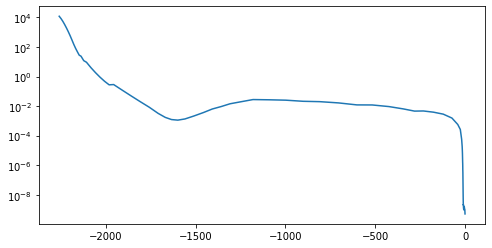

In [46]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(atmos.Z[::]*1E-5, tau[600,:])
ax.set_yscale("log")
plt.show()

In [47]:
# calculate total extinction and emmisivity
alp_total = alp_rt + alp_c
src_total = (eta_rt + eta_c + eps_c * Jbar) / (alp_total)

# optical depth
dtau = np.zeros((spectrum.nSpectrum,nZ), dtype="float64")
#dtau = np.zeros((spectrum.nSpectrum,nZ), dtype="float64")
for ks in range(spectrum.nSpectrum):
    wave = spectrum.spectrum[ks]
    dtau[ks,0]  = 0.5 * alp_total[ks,0] * (atmos.Z[0]-atmos.Z[1])
    dtau[ks,1:] = 0.5 * (alp_total[ks,:-1]+alp_total[ks,1:]) * (atmos.Z[:-1]-atmos.Z[1:])

# compute tau
tau = dtau.cumsum(axis=1)

In [28]:
from spectra_src.Experimental import ExFeautrier as _ExFeautrier

# boundary condition
I_lower = np.zeros((nray, spectrum.nSpectrum), dtype="float64")
for kr in range(nray):
    I_lower[kr,:] = _LTELib.planck_cm_(spectrum.spectrum[:], atmos.Te[-1])

# solve radiative transfer for (ray, wavelength)
for ks in range(spectrum.nSpectrum):
    Pnew = np.zeros(nZ, dtype="float64")
    for kr in range(nray):
        mu = mus[kr]
        weight = weights[kr]
        #I_l = I_lower[kr, ks]
        #wave = spectrum.spectrum[ks]
        Pnew[:] += weight * _ExFeautrier.formal_improved_RH_(tau[ks,:], src_total[ks,:], mu, r0=0, h0=0, rn=1, hn=0)
    Jbar[ks,:] = Pnew[:]


